In [35]:
from whoosh.analysis import *
import os
import re
from pathlib import Path
from nltk.tokenize import RegexpTokenizer
from collections import Counter
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.exceptions import ConvergenceWarning
import numpy as np
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import random
random.seed()
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import RegexpStemmer

In [36]:
DATA_DIR = "20_newsgroups"

## Functions from lab

In [37]:
def clean_file_text(text):
    new_text = re.sub("Newsgroups:.*?\n", "", text)
    new_text = re.sub("Xref:.*?\n", "", new_text)
    new_text = re.sub("Path:.*?\n", "", new_text)
    new_text = re.sub("Date:.*?\n", "", new_text)
    new_text = re.sub("Followup-To:.*?\n", "", new_text)
    return new_text

In [38]:
def corpus_count_words(file_list):
    tokenizer = RegexpTokenizer(r'\w+')
    word_counter = Counter()
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            word_counter.update(file_words)
    return word_counter

In [39]:
def get_topic_name(file_path):
    return file_path.parent.name

def get_target(topic_name):
    topics = ['talk.politics.mideast', 'rec.autos', 'comp.sys.mac.hardware', 'alt.atheism', 'rec.sport.baseball', 
     'comp.os.ms-windows.misc', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'talk.politics.misc', 
     'rec.motorcycles', 'comp.windows.x', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.electronics',
     'talk.politics.guns', 'sci.space', 'soc.religion.christian', 'misc.forsale', 'talk.religion.misc']
    return topics.index(topic_name)

In [40]:
def plot_confusion_matrix(cm):
    # plot the confusion matrix
    plt.figure(figsize=(10,10))
    plt.matshow(cm, fignum=1)
    
    # add labels for all targets
    num_targets = cm.shape[0]
    plt.xticks(list(range(num_targets+1)))
    plt.yticks(list(range(num_targets+1)))

## Q1

In [41]:
all_files = [pth for pth in Path(DATA_DIR).glob("**/*") if pth.is_file() and not pth.name.startswith(".")]

In [42]:
def binary_baseline_data(file_list, num_words = 1000):
    # Calculate word count in corpus
    news_cnt = corpus_count_words(file_list)
    
    # Select the most common numWords
    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    
    # Create a binary encoding of dataset based on the selected features (X)
    tokenizer = RegexpTokenizer(r'\w+')
    df_rows = []
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            df_rows.append([1 if word in file_words else 0 for word in word_list])      
    X = pd.DataFrame(df_rows, columns = word_list)
    
    # Create a dataframe of targets (y)
    y = [get_target(get_topic_name(file_path)) for file_path in file_list]
    
    return X, y

In [44]:
# get the baseline data
X, y = binary_baseline_data(all_files)

# split to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# train a logistic regression classifier
clf = LogisticRegression(C=1.0).fit(X_train, y_train)

# predict on train and test set
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

# calculate train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)

# report results
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))

Train accuracy: 0.9124812459812817
Test accuracy: 0.6978333333333333


### Q1 (a)

feature set is binary of  the appearance of top 1000 words amount all the data.  
the amount of data is all the different documents.  
one of the hyper parameters used in this baseline is logic regression's preremeter C. smaller values specify stronger regularization. Another hyper parameter is the the size of feature set, in this case is 1000.

### Q1 (b)

Modify the following function:

In [43]:
def  binary_improved_data(file_list, num_words = 1000):
    # Calculate word count in corpus
    nltk.download('punkt')
    nltk.download('stopwords')
    df_rows = []
    stop = set(stopwords.words('english'))
    st = RegexpStemmer('ing$|s$|e$|able$', min=4)
    tokenizer = RegexpTokenizer(r'\w+')
    
    word_counter = Counter()
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_data = st.stem(file_data.lower())
            file_words =tokenizer.tokenize(file_data)
            file_words = [i for i in file_words if i not in stop]
            
            word_counter.update(file_words)
     
    word_list = [word for (word, freq) in word_counter.most_common(num_words)]
    
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_data =st.stem(file_data.lower())
            file_words =tokenizer.tokenize(file_data)
            file_words = [i for i in file_words if i not in stop]
            df_rows.append([1 if word in file_words else 0 for word in word_list])
 
    X = pd.DataFrame(df_rows, columns = word_list)
    
    # Create a dataframe of targets (y)
    y = [get_target(get_topic_name(file_path)) for file_path in file_list]
    
    return X, y

### Q1 (c)

Modify the following partial code to calculate the train and test accuracy and answer the question in the markdown cell below

In [46]:
# get the baseline data
X, y = binary_improved_data(all_files)

# split to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# train a logistic regression classifier
clf = LogisticRegression(C=1.0).fit(X_train, y_train)

# predict on train and test set
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

# calculate train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)




# report results
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\samxf1995\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samxf1995\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Train accuracy: 0.9249124812459812
Test accuracy: 0.7326666666666667


Test accuracy and train accuracy are both improved.

### Q1 (d)

Modify the partial code below

In [47]:
def random_mean_ci(X, y, num_tests):
    # train_results is a list of train accuracy results for the differrent random splits of the dataset
    train_results = []
    
    # test_results is a list of test accuracy results for the differrent random splits of the dataset
    test_results = []
    
    # split to train and test set
    for i in range(0,num_tests-1):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random.randint(1,1000))

    # train a logistic regression classifier
        clf = LogisticRegression(C=1.0).fit(X_train, y_train)
    
    # predict on train and test set
        y_train_predict = clf.predict(X_train)
        y_test_predict = clf.predict(X_test)

    # calculate train and test accuracy
        train_accuracy = accuracy_score(y_train, y_train_predict)
        test_accuracy = accuracy_score(y_test, y_test_predict)
        train_results.append(train_accuracy)
        test_results.append(test_accuracy)
    
    
    # calculate the train mean and the 95% confidence interval for the list of results
    train_mean = np.mean(train_results)
    train_ci_low, train_ci_high = stats.t.interval(0.95, len(train_results)-1, loc=train_mean, scale=stats.sem(train_results))
    
    # calculate the test mean and the 95% confidence interval for the list of results
    test_mean = np.mean(test_results)
    test_ci_low, test_ci_high = stats.t.interval(0.95, len(test_results)-1, loc=test_mean, scale=stats.sem(test_results))
    
    # validate return types
    assert isinstance(train_mean, float) and isinstance(train_ci_low, float) and isinstance(train_ci_high, float), "return types"
    assert isinstance(test_mean, float) and isinstance(test_ci_low, float) and isinstance(test_ci_high, float), "return types"
    
    return train_mean, train_ci_low, train_ci_high, test_mean, test_ci_low, test_ci_high

### Q1 (e)

Use the following code to calculate the mean accuracy and 95% confidence interval over 10 random splits

In [48]:
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = random_mean_ci(X, y, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.9250791836345884
Train confidence interval over 10 random splits: [0.92424181759607, 0.9259165496731068]
Test mean accuracy over 10 random splits: 0.7382037037037037
Test confidence interval over 10 random splits: [0.735143224737733, 0.7412641826696744]


This tell me the result has small variations though out different splits. This tells me the bias of the model is low. There is more information since if one split is high that can be lucky.

### Q1 (f)

Modify the partial code below

In [49]:
def random_cm(X, y, num_tests):
    # cm_list is a list of confusion matrices for the different random splits of the dataset
    cm_list = []
    
    # split to train and test set
    for i in range(0,num_tests-1):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random.randint(1,1000))

    # train a logistic regression classifier
        clf = LogisticRegression(C=1.0).fit(X_train, y_train)
    
    # predict on train and test set
        y_train_predict = clf.predict(X_train)
        y_test_predict = clf.predict(X_test)

        cm_list.append(confusion_matrix(y_test, y_test_predict))
    
    # sum the confusion matrices and return the combined confusion matrix
        combined_cm = pd.Panel(cm_list).sum(axis=0)
    
    # validate return type
    assert isinstance(combined_cm, pd.DataFrame), "return type"
    
    return combined_cm

### Q1 (g)

Use the following code to produce a confusion matrix for 10 random splits

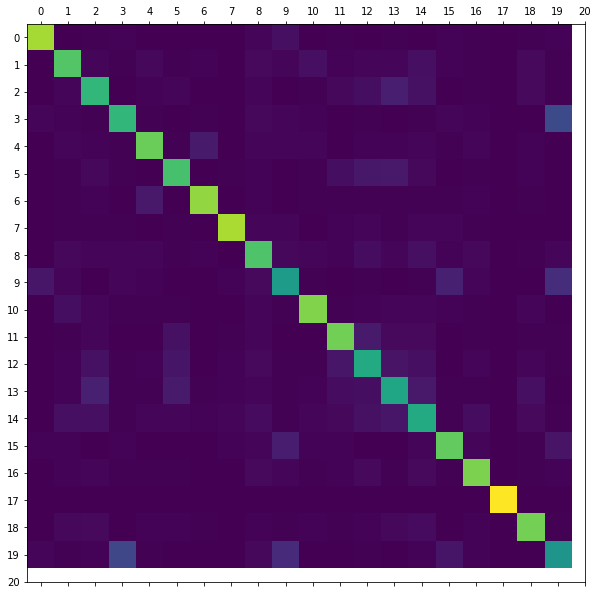

In [50]:
cm10 = random_cm(X, y, num_tests = 10)
plot_confusion_matrix(cm10)

In [51]:
pd.DataFrame(cm10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,2356,7,15,23,10,4,9,7,33,114,3,19,7,12,10,25,12,0,11,22
1,7,1988,40,17,56,12,22,8,73,32,109,25,33,35,113,26,21,0,74,12
2,1,34,1803,10,22,40,5,5,33,9,14,62,106,233,123,9,19,4,73,13
3,32,22,21,1804,15,9,21,10,57,38,23,10,16,2,15,36,27,5,8,611
4,4,38,26,14,2104,21,193,5,53,42,33,9,27,22,52,20,32,0,25,9
5,0,18,59,15,10,1930,3,12,30,7,17,100,173,189,58,3,14,0,23,4
6,4,14,22,1,189,4,2275,2,23,5,12,11,15,11,21,17,30,0,18,4
7,1,13,19,11,7,17,2,2372,32,37,5,28,51,14,50,43,18,0,7,8
8,8,54,46,36,45,15,25,9,1971,56,39,30,88,32,107,26,59,1,14,39
9,161,34,9,44,29,10,7,26,65,1506,13,10,13,10,13,239,34,1,10,352


Yes, for example topic 4 and 20 they are both talk about religons, so there are lot of common words like god or Chrstian.

## Q2

### Q2 (a)

Modify the partial code below

In [52]:
def feature_num(X, y):
    # result_list is a list of tuples (num_features, train_accuracy, test_accuracy)
    # where numFeatures is the number of words used as features
    result_list = []
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    for p in [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]:
        subset_size = int(p*X.shape[1])
        X_train_subset = X_train.iloc[:, 0:subset_size]
        X_test_subset = X_test.iloc[:, 0:subset_size]
        # Write your code here to calculate train_accuracy and test_accuracy for the current subset of features
        
        # train a logistic regression classifier
        clf = LogisticRegression(C=1.0).fit(X_train_subset, y_train)

        # predict on train and test set
        y_train_predict = clf.predict(X_train_subset)
        y_test_predict = clf.predict(X_test_subset)

        # calculate train and test accuracy
        train_accuracy = accuracy_score(y_train, y_train_predict)
        test_accuracy = accuracy_score(y_test, y_test_predict)
        
        # add to result_list
        result_list.append((p, train_accuracy, test_accuracy))
        
    # Make a dataframe of the results
    result_df = pd.DataFrame(result_list, columns=["num_features", "train_accuracy", "test_accuracy"])
    
    # validate return type
    assert isinstance(result_df, pd.DataFrame), "return type"
    
    return result_df

### Q2 (b)

Use the following code to plot the train and test accuracy for the different feature sets sizes

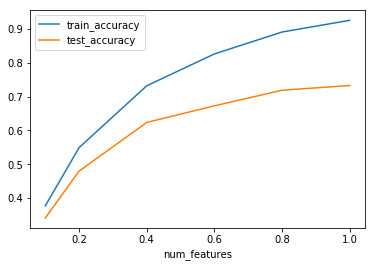

In [54]:
feature_num_df = feature_num(X, y)
feature_num_df.plot(x="num_features", y=["train_accuracy", "test_accuracy"])

By observation, accuracy is higher with more features.

## Q3

### Q3 (a)

Modify the partial code below

In [53]:
def hyperparameter(X, y):
    # result_list is a list of tuples (num_features, train_accuracy, test_accuracy)
    # where numFeatures is the number of words used as features
    result_list = []
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    for param in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
        # Write your code here to calculate train_accuracy and test_accuracy for the current parameter value
        
        clf = LogisticRegression(C=param).fit(X_train, y_train)
    
    # predict on train and test set
        y_train_predict = clf.predict(X_train)
        y_test_predict = clf.predict(X_test)
        
        train_accuracy = accuracy_score(y_train, y_train_predict)
        test_accuracy = accuracy_score(y_test, y_test_predict)
        
        # add to result_list
        result_list.append((param, train_accuracy, test_accuracy))
        
    # Make a dataframe of the results
    result_df = pd.DataFrame(result_list, columns=["param", "train_accuracy", "test_accuracy"])
    
    # validate return type
    assert isinstance(result_df, pd.DataFrame), "return type"
    
    return result_df

### Q3 (b)

Use the following code to plot the train and test accuracy for the different the parameters

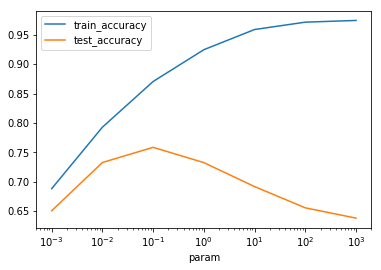

In [55]:
param_df = hyperparameter(X, y)
param_df.plot(x="param", y=["train_accuracy", "test_accuracy"], logx=True)

The highest accuracy occur when hyperparameter C at 0.1 to 1 with right anout of regularization

## Q4

### Q4 (a)

Modify the partial code below

In [56]:
def tf_improved_data(file_list, num_words = 1000):
    # Put your code here
    # Make sure you update the variable features and targets below
    
    X = None
    y = None
    
    # validate return types
    assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
    
    return X, y

In [57]:
def  tf_improved_data(file_list, num_words = 1000):
    # Calculate word count in corpus
    nltk.download('punkt')
    nltk.download('stopwords')
    df_rows = []
    stop = set(stopwords.words('english'))
    st = RegexpStemmer('ing$|s$|e$|able$', min=4)
    tokenizer = RegexpTokenizer(r'\w+')
    
    word_counter = Counter()
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_data = st.stem(file_data.lower())
            file_words =tokenizer.tokenize(file_data)
            file_words = [i for i in file_words if i not in stop]
            
            word_counter.update(file_words)
     
    word_list = [word for (word, freq) in word_counter.most_common(num_words)]
    
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_data =st.stem(file_data.lower())
            file_words =tokenizer.tokenize(file_data)
            file_words = [i for i in file_words if i not in stop]
            df_rows.append([file_words.count(word) if word in file_words else 0 for word in word_list])
 
    X = pd.DataFrame(df_rows, columns = word_list)
    
    # Create a dataframe of targets (y)
    y = [get_target(get_topic_name(file_path)) for file_path in file_list]
    
    return X, y

### Q4 (b)

Use the following code to calculate the mean accuracy and 95% confidence interval over multiple random splits

In [58]:
X_tf, y_tf = tf_improved_data(all_files)
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = random_mean_ci(X_tf, y_tf, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\samxf1995\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samxf1995\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Train mean accuracy over 10 random splits: 0.9163471537551698
Train confidence interval over 10 random splits: [0.9122797585487801, 0.9204145489615596]
Test mean accuracy over 10 random splits: 0.7199259259259259
Test confidence interval over 10 random splits: [0.7156112588727347, 0.724240592979117]


Results for TF and binary are similar,even a bit lower which means tf is not so important when we deal with lots of features.

## Q5

### Q5 (a)

Modify the partial code below

In [59]:
def nb_random_mean_ci(X, y, num_tests):
    # train_results is a list of train accuracy results for the differrent random splits of the dataset
    train_results = []
    
    # test_results is a list of test accuracy results for the differrent random splits of the dataset
    test_results = []
    
    # split to train and test set
    for i in range(0,num_tests-1):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random.randint(1,1000))

    # train a logistic regression classifier
        clf = GaussianNB().fit(X_train, y_train)
    
    # predict on train and test set
        y_train_predict = clf.predict(X_train)
        y_test_predict = clf.predict(X_test)

    # calculate train and test accuracy
        train_accuracy = accuracy_score(y_train, y_train_predict)
        test_accuracy = accuracy_score(y_test, y_test_predict)
        train_results.append(train_accuracy)
        test_results.append(test_accuracy)
    
    
    # calculate the train mean and the 95% confidence interval for the list of results
    train_mean = np.mean(train_results)
    train_ci_low, train_ci_high = stats.t.interval(0.95, len(train_results)-1, loc=train_mean, scale=stats.sem(train_results))
    
    # calculate the test mean and the 95% confidence interval for the list of results
    test_mean = np.mean(test_results)
    test_ci_low, test_ci_high = stats.t.interval(0.95, len(test_results)-1, loc=test_mean, scale=stats.sem(test_results))
    
    # validate return types
    assert isinstance(train_mean, float) and isinstance(train_ci_low, float) and isinstance(train_ci_high, float), "return types"
    assert isinstance(test_mean, float) and isinstance(test_ci_low, float) and isinstance(test_ci_high, float), "return types"
    
    return train_mean, train_ci_low, train_ci_high, test_mean, test_ci_low, test_ci_high

### Q5 (b)

Use the following code to calculate the mean accuracy and 95% confidence interval over multiple random splits

In [62]:
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = nb_random_mean_ci(X, y, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.5983583783826693
Train confidence interval over 10 random splits: [0.5885230196301345, 0.608193737135204]
Test mean accuracy over 10 random splits: 0.5317222222222221
Test confidence interval over 10 random splits: [0.5224061402796715, 0.5410383041647727]


Logistic Regression perform better because NB assumed labels are independent.

## Q6

In [61]:
def is_graduate_student():
    # ** Graduate students: change the return value to True **
    return True

### Q6 (a)

Modify the partial code below

In [60]:
def  binary_med_data(file_list, num_words = 1000):
    # Calculate word count in corpus
    nltk.download('punkt')
    nltk.download('stopwords')
    df_rows = []
    stop = set(stopwords.words('english'))
    st = RegexpStemmer('ing$|s$|e$|able$', min=4)
    tokenizer = RegexpTokenizer(r'\w+')
    
    word_counter = Counter()
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_data = st.stem(file_data.lower())
            file_words =tokenizer.tokenize(file_data)
            file_words = [i for i in file_words if i not in stop]
            
            word_counter.update(file_words)
     
    word_list = [word for (word, freq) in word_counter.most_common(num_words)]
    
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_data =st.stem(file_data.lower())
            file_words =tokenizer.tokenize(file_data)
            file_words = [i for i in file_words if i not in stop]
            df_rows.append([1 if word in file_words else 0 for word in word_list])
 
    X = pd.DataFrame(df_rows, columns = word_list)
    
    # Create a dataframe of targets (y)
    y = [1 if get_topic_name(file_path) == 'sci.med' else 0 for file_path in file_list]
    
       # validate return types
    assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
    
    return X, y

### Q6 (b)

Use the following code to calculate the mean accuracy and 95% confidence interval over multiple random splits

In [63]:
X, y = binary_med_data(all_files)
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = random_mean_ci(X, y, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\samxf1995\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samxf1995\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Train mean accuracy over 10 random splits: 0.9877354671239075
Train confidence interval over 10 random splits: [0.9873039258439466, 0.9881670084038684]
Test mean accuracy over 10 random splits: 0.9705
Test confidence interval over 10 random splits: [0.9693399024681743, 0.9716600975318258]


It more accurate because there are less catagory with lower independency.